CSV loaded successfully!

First 5 rows:
       Time       Avg
0   7/1/10  0.064460
1   8/1/10  0.064572
2   9/1/10  0.061903
3  10/1/10  0.108899
4  11/1/10  0.258841

Columns: ['Time', 'Avg']
Shape: (187, 2)

Date range: 2010-07 to 2026-01
Valid points: 187
Price range: $0.06 – $115,795.13


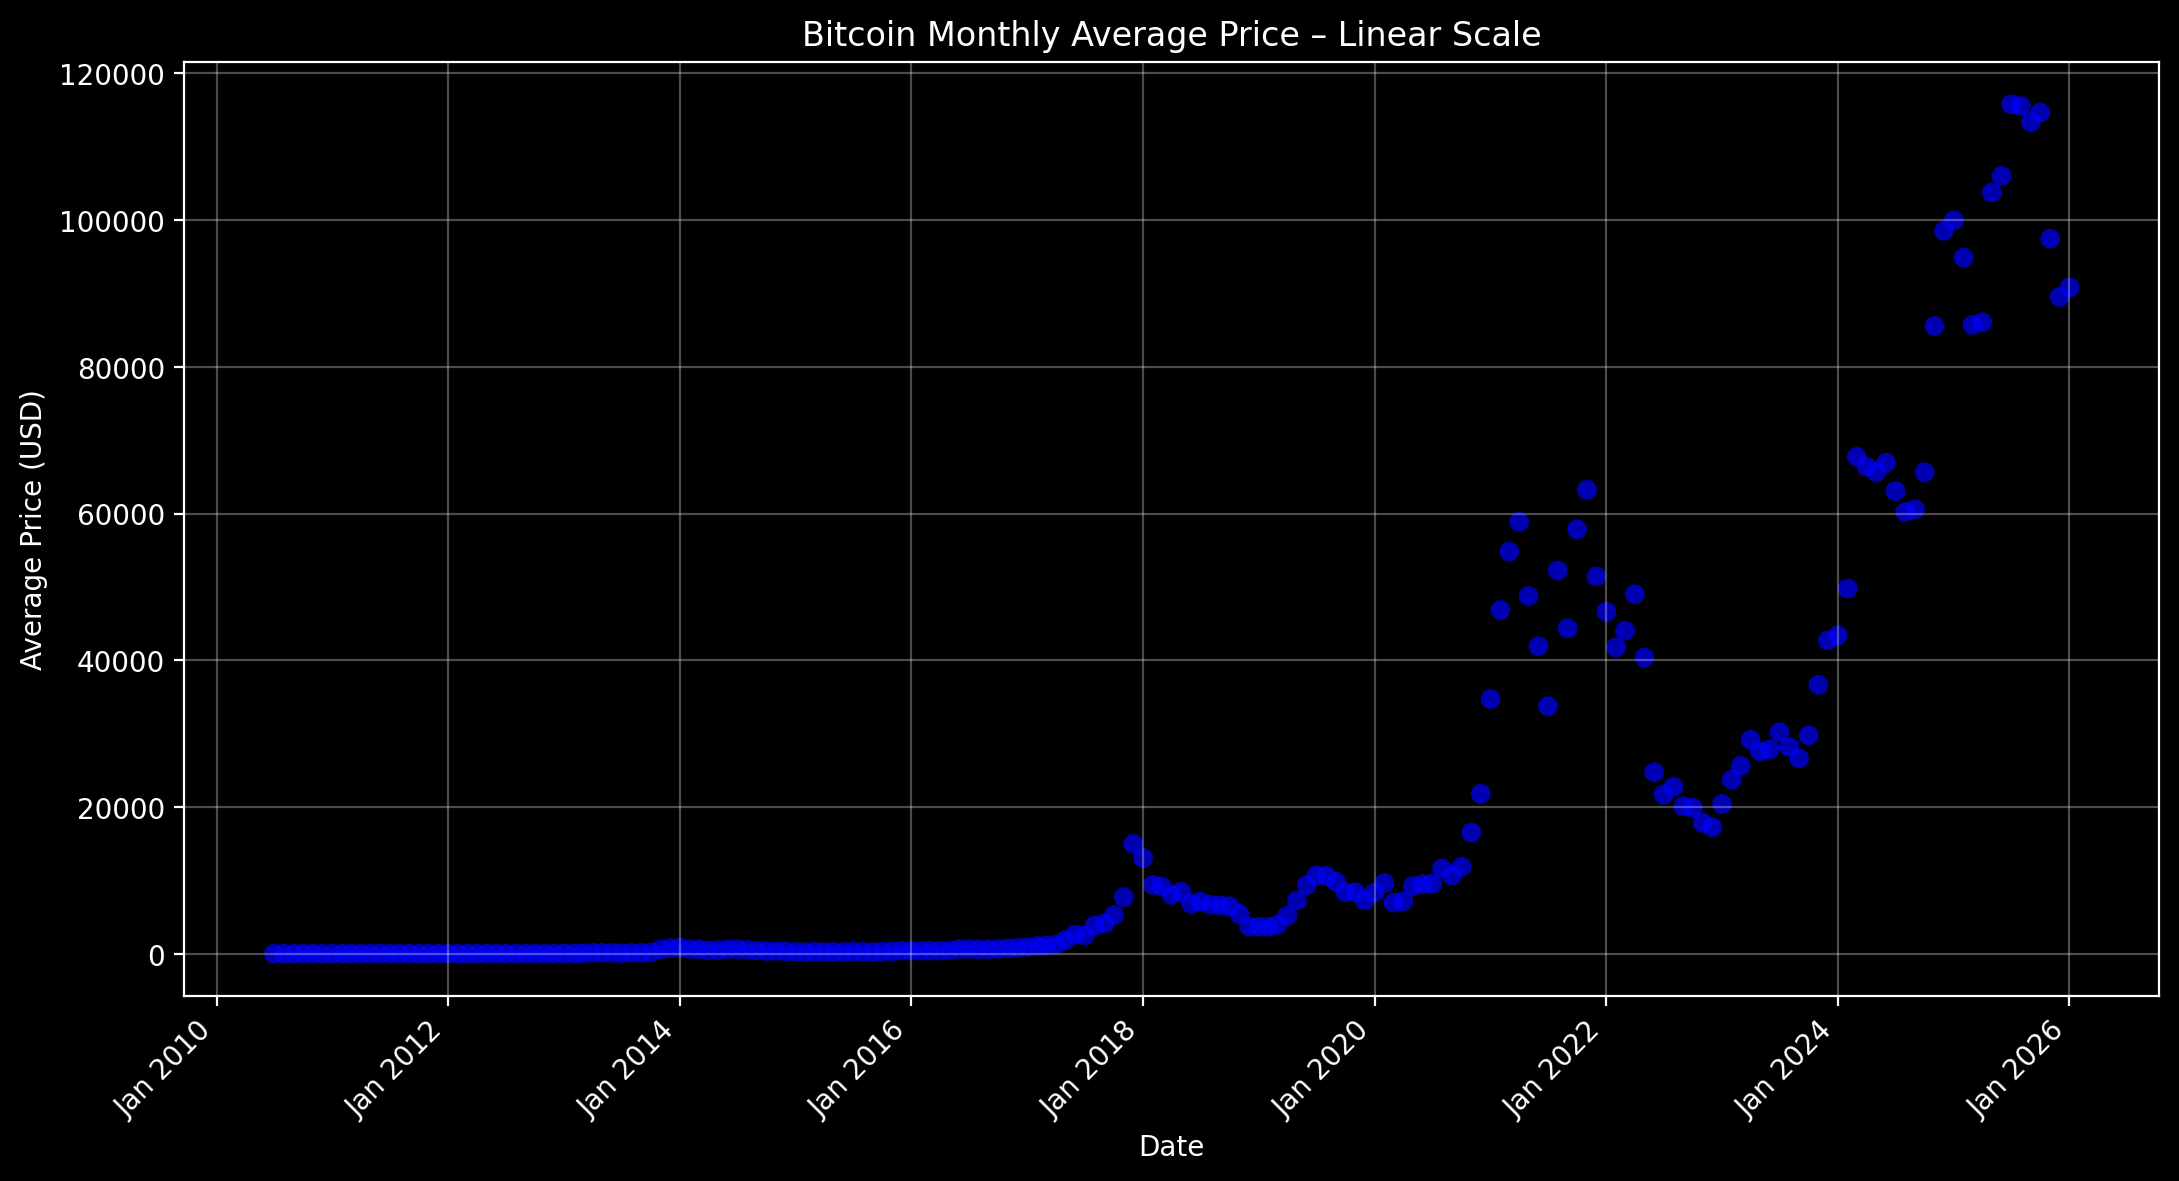


Power-law fit:  y ≈ A × (years since 2009)^B
  Exponent (B)  = 5.6615
  Prefactor (A) = 1.3180e-02
  R²            = 0.9624
  Points used   = 187 (from year 1.5 onward)


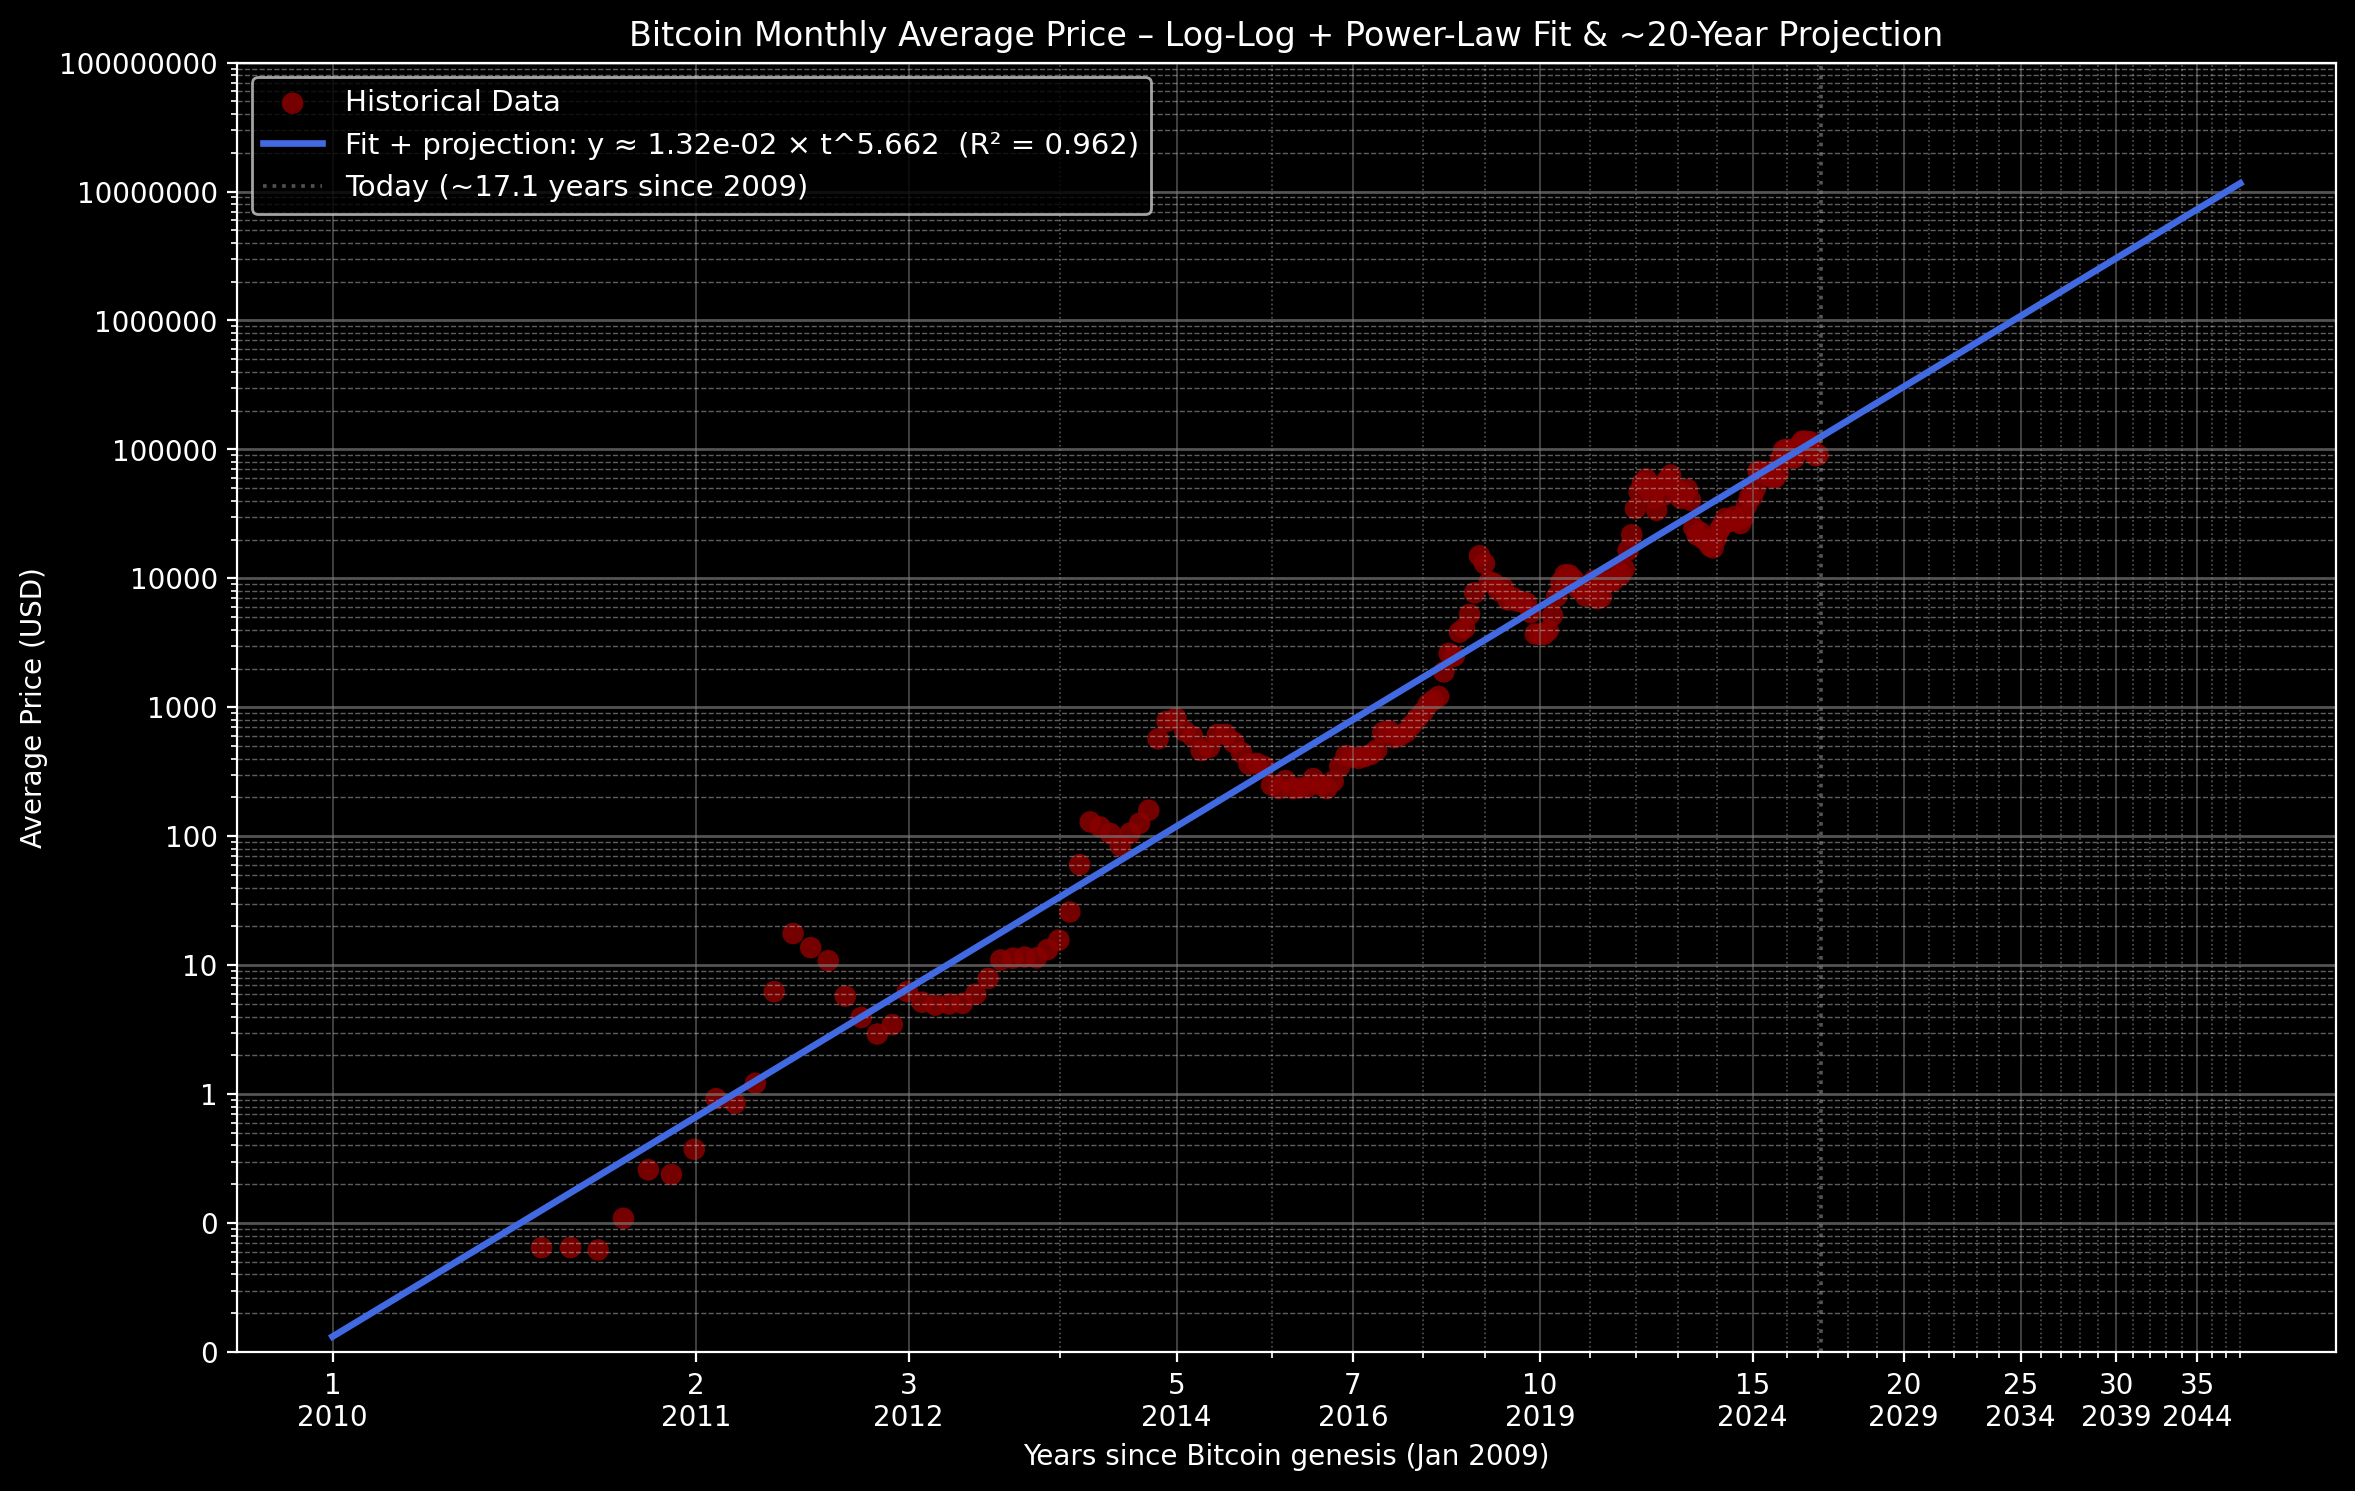

In [1]:
# Bitcoin Monthly Prices — Linear + Log-Log + Power-Law Fit & 20-Year Projection
# Y-axis: major grid at EVERY power of 10 + minor grid at 2×–9×
# FIXED: floating-point exponentiation to avoid ValueError on negative powers
# Juno notebook compatible — February 2026

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from matplotlib.ticker import FixedLocator, ScalarFormatter

# ── CHANGE THIS TO YOUR ACTUAL FILE PATH ─────────────────────────
csv_path = './bitcoin/BitcoinMonthlyPricesD.csv'

# ── Load and clean data ───────────────────────────────────────────
try:
    df = pd.read_csv(csv_path)
    print("CSV loaded successfully!")
    print("\nFirst 5 rows:\n", df.head())
    print("\nColumns:", list(df.columns))
    print("Shape:", df.shape)
except FileNotFoundError:
    print(f"File not found: {csv_path}")
    print("Tip: Use !pwd or check Files → Juno folder")
except Exception as e:
    print("Error loading CSV:", str(e))

date_column  = 'Time'
value_column = 'Avg'

df[date_column] = pd.to_datetime(df[date_column], format='%m/%d/%y', errors='coerce')
df = df.dropna(subset=[date_column])
df = df.sort_values(date_column)

x_dates = df[date_column]
y_data  = df[value_column].astype(float)

# Summary
print("\nDate range:", x_dates.min().strftime('%Y-%m'),
      "to", x_dates.max().strftime('%Y-%m'))
print("Valid points:", len(y_data))
print(f"Price range: ${y_data.min():,.2f} – ${y_data.max():,.2f}")

# ── Plot 1: Linear scale ──────────────────────────────────────────
plt.figure(figsize=(11, 6))
plt.scatter(x_dates, y_data, color='blue', alpha=0.7, s=50, edgecolor='none')
plt.xlabel('Date')
plt.ylabel('Average Price (USD)')
plt.title('Bitcoin Monthly Average Price – Linear Scale')
plt.grid(True, alpha=0.3)

plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.AutoDateLocator(maxticks=12))
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ── Prepare data for log-log plot ─────────────────────────────────
valid = y_data > 0
y_valid = y_data[valid]
x_dates_valid = x_dates[valid]

# Years since Bitcoin genesis (2009-01-03)
genesis = pd.to_datetime('2009-01-03')
years_since = (x_dates_valid - genesis).dt.days / 365.25
years_valid = years_since.astype(float)

# Filter to start from ~1 year onward
MIN_YEARS=1.0
reasonable = years_valid >= MIN_YEARS
years_log = years_valid[reasonable]
y_log     = y_valid[reasonable]

# ── Log-Log Plot + Power-Law Fit + 20-Year Projection ─────────────
if len(y_log) < 10:
    print("Not enough positive data points for fitting (after year 1 filter).")
else:
    log_x = np.log10(years_log)
    log_y = np.log10(y_log)

    slope, intercept, r_value, _, _ = linregress(log_x, log_y)
    B = slope
    A = 10 ** intercept

    print("\nPower-law fit:  y ≈ A × (years since 2009)^B")
    print(f"  Exponent (B)  = {B:.4f}")
    print(f"  Prefactor (A) = {A:.4e}")
    print(f"  R²            = {r_value**2:.4f}")
    print(f"  Points used   = {len(log_x)} (from year {years_log.min():.1f} onward)")#print(f"  Points used   = {len(log_x)} (from year ~1 onward)")

    # ── Create figure ─────────────────────────────────────────────
    plt.figure(figsize=(12, 7.5))

    # Historical data
    plt.scatter(years_log, y_log, color='darkred', alpha=0.85, s=60,
                edgecolor='none', label='Historical Data')

    # Projection
    years_plot = np.linspace(1.0, 38.0, 800)
    y_plot = A * years_plot ** B

    plt.plot(years_plot, y_plot, color='royalblue', lw=2.4,
             label=f'Fit + projection: y ≈ {A:.2e} × t^{B:.3f}  (R² = {r_value**2:.3f})')

    plt.xscale('log')
    plt.yscale('log')

    
    
    
    
    
    
    
    from matplotlib.ticker import NullFormatter
    plt.gca().xaxis.set_minor_formatter(NullFormatter())

    # Option B: Also force major formatter to only show your explicit ticks
    plt.gca().xaxis.set_major_formatter(plt.ScalarFormatter(useOffset=False))
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x:g}' if x in x_tick_values else ''))

    # Your custom major ticks (these will show normally)
    x_tick_values = [1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 35]
    plt.xticks(x_tick_values, [str(int(y)) for y in x_tick_values])

    # ── Minor locator for grid lines only (no labels) ─────────────────────────────
    min_year = 1
    max_year = 38
    every_year = np.arange(min_year, max_year + 1)
    plt.gca().xaxis.set_minor_locator(FixedLocator(every_year))

    # Minor grid: vertical lines every year (no labels attached)
    plt.grid(which='minor', axis='x',
             color='lightgray', linestyle=':', linewidth=0.6, alpha=0.4)

    # Major grid
    plt.grid(which='major', axis='x',
             color='gray', linestyle='-', linewidth=0.9, alpha=0.55)
    
    
        # Nuclear option: remove ALL automatic minor tick labels
    plt.gca().xaxis.set_minor_formatter(NullFormatter())
    plt.gca().xaxis.set_minor_locator(plt.NullLocator())   # ← this removes minor ticks entirely
    # Then re-add the locator ONLY for grid (without labels)
    plt.gca().xaxis.set_minor_locator(FixedLocator(every_year))
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    plt.xlabel('Years since Bitcoin genesis (Jan 2009)')
    plt.ylabel('Average Price (USD)')
    plt.title('Bitcoin Monthly Average Price – Log-Log + Power-Law Fit & ~20-Year Projection')

    # ── EXPLICIT Y-AXIS TICKS & GRID ────────────────────────────────────────────
    # Define exponents covering typical BTC price range
    exponents = np.arange(-2, 10)  # 0.01 to 100,000,000

    # Major ticks = every power of 10
    major_positions = 10.0 ** exponents  # use 10.0 to force float exponentiation
    plt.gca().yaxis.set_major_locator(FixedLocator(major_positions))

    # Formatter: plain numbers, no scientific notation, no offset
    fmt = ScalarFormatter(useOffset=False)
    fmt.set_scientific(False)
    plt.gca().yaxis.set_major_formatter(fmt)

    # Minor ticks = 2× to 9× each decade
    minor_positions = []
    for exp in exponents:
        for sub in range(2, 10):
            minor_positions.append(sub * (10.0 ** exp))  # FIXED: 10.0 ** exp

    plt.gca().yaxis.set_minor_locator(FixedLocator(minor_positions))

    # ── Grid lines ──────────────────────────────────────────────────────────────
    # Major grid: solid at every power of 10
    plt.grid(which='major', axis='y',
             color='gray', linestyle='-', linewidth=1.0, alpha=0.65)

    # Minor grid: dashed, faint at 2×–9×
    plt.grid(which='minor', axis='y',
             color='lightgray', linestyle='--', linewidth=0.5, alpha=0.45)

    # Keep x-grid subtle
    plt.grid(which='major', axis='x', color='gray', linestyle='-', linewidth=0.7, alpha=0.5)
    plt.grid(which='minor', axis='x', color='lightgray', linestyle='--', linewidth=0.5, alpha=0.45)
    

    
    ##
    min_year = 1
    max_year = 38   # ~2047
    every_year = np.arange(min_year, max_year + 1, 1)   # 1,2,3,...,38

# Convert integer years to log scale positions
    x_every_year_log = every_year   # already in the same unit as years_log

# ── Use these positions for MINOR grid lines (vertical lines every year)
    plt.gca().xaxis.set_minor_locator(FixedLocator(x_every_year_log))

# Draw the minor grid lines (dashed vertical lines at each integer year)
    plt.grid(which='minor', axis='x',
         color='lightgray', linestyle=':', linewidth=0.6, alpha=0.4)

# Optional: make major grid lines a bit stronger if ne

    # Reasonable y-limits to show many decades
    plt.ylim(0.01, 1e8)   # increase to 1e9 or 1e10 if projection goes higher

    # ── X-axis: starts at 1, log ticks ────────────────────────────
    x_tick_values = [1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 35]
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
        
        
        
        
        
        
        
        
        
        
        
        
        
        
    
    
    
    
        
    plt.xticks(x_tick_values, [str(int(y)) for y in x_tick_values])

    # Today marker
    today_years = (pd.to_datetime('today') - genesis).days / 365.25
    plt.axvline(today_years, color='gray', ls=':', lw=1.3, alpha=0.65,
                label=f'Today (~{today_years:.1f} years since 2009)')

    plt.legend(loc='upper left', fontsize=10.5)
    plt.tight_layout(pad=1.5)
    
    
# ── Dual labels on bottom x-axis ──────────────────────────────────────────────
# Get current tick locations and "years since" labels
current_xticks = x_tick_values
years_since_labels = [str(int(y)) for y in current_xticks]

# Corresponding calendar years
calendar_labels = [f"{2009 + int(y)}" for y in current_xticks]

# Create combined labels (two lines per tick)
combined_labels = [f"{ys}\n{cal}" for ys, cal in zip(years_since_labels, calendar_labels)]

# Apply the two-line labels
plt.xticks(current_xticks, combined_labels)

# Optional: make the "years since" smaller or italic to distinguish
for label in plt.gca().get_xticklabels():
    label.set_fontsize(10)  # slightly smaller overall
    # or more advanced: make top line smaller via manual Text objects (harder)
    
    plt.show()